In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ABENet(nn.Module):
    def __init__(self, N, has_key=True):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=2*N if has_key else N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

![symmetric_encryption](img/symmetric_enc.png)

In [29]:
N = 16 # [16, 32, 64]
minibatch_size = 4096 # [256..4096]

A = ABENet(N, has_key=True).to(DEVICE)
B = ABENet(N, has_key=True).to(DEVICE)
E = ABENet(N, has_key=False).to(DEVICE)

In [6]:
#l1_norm = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
l1_norm = nn.L1Loss()
loss_eve = l1_norm
loss_bob = l1_norm
#loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((N/2 - loss_eve(P_eve, P))**2) / ((N/2)**2))
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

In [7]:
def reconstruction_error(Out, Original):
    return torch.mean( torch.sum( torch.sign(Original) != torch.sign(Out), dim=1)
                       .to(torch.float), dim=0).item()

In [8]:
def gen_bitstring(N, batch_size=minibatch_size):
    return torch.randint(low=0, high=2, size=(batch_size,N), dtype=torch.float).to(DEVICE)*2-1

In [27]:
def train_abe(A, B, E,
              lr=0.0008,
              max_iter=150000,
              debug_print=1000,
              loss_eve=loss_eve,
              loss_alicebob=loss_alicebob,
              stop_condition=(lambda AB_loss, E_loss, AB_rec, E_rec:
                              #AB_loss < 0.005 and E_loss > 0.5
                              AB_rec < 0.05 and E_rec > 7.5)):
    
    # Optimizers
    A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
    B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
    E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

    ABs = [] # AB loss values
    Es  = [] # E loss values

    Rec_B = []
    Rec_E = []
    
    [X.train() for X in [A,B,E]] # Set models in training mode

    start_time = time.time()
    for ic in range(max_iter):
        # Train A/B for 1 minibtach and E for 2 minibatches to give it some advantage
        for who, num_minibatches in [('AB', 1), ('E', 2)]:
            for _ in range(num_minibatches):
                P = gen_bitstring(N, batch_size=minibatch_size)
                K = gen_bitstring(N, batch_size=minibatch_size) 

                C     = A(torch.cat((P, K), dim=1))
                P_bob = B(torch.cat((C, K), dim=1))
                P_eve = E(C)

                if who == 'AB':
                    A_optimizer.zero_grad()
                    B_optimizer.zero_grad()
                    AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                    AB_loss.backward()
                    A_optimizer.step()
                    B_optimizer.step()
                
                elif who == 'E':
                    E_optimizer.zero_grad()
                    E_loss  = loss_eve(P_eve, P)
                    
                    E_loss.backward()
                    E_optimizer.step()

        if debug_print > 0 and ic % debug_print == (debug_print-1):
            elapsed_time = time.time() - start_time
            print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
                ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

        AB_rec = reconstruction_error(P, P_bob)
        E_rec = reconstruction_error(P, P_eve)
        Rec_B.append(AB_rec)
        Rec_E.append(E_rec)
        ABs.append(AB_loss.item())
        Es.append(E_loss.item())

        if stop_condition(AB_loss, E_loss, AB_rec, E_rec):
            break

    [X.train(False) for X in [A,B,E]]
    return ABs, Es, Rec_B, Rec_E

In [30]:
ABs, Es, RBs, ERs = train_abe(A,B,E, max_iter=15000)

[  1000] AB_loss: 1.0012 E_loss: 0.9985 Elapsed Time: 00:00:34


[  2000] AB_loss: 1.0029 E_loss: 0.9963 Elapsed Time: 00:01:08


[  3000] AB_loss: 1.0014 E_loss: 1.0021 Elapsed Time: 00:01:43


[  4000] AB_loss: 0.1140 E_loss: 0.7545 Elapsed Time: 00:02:17


[  5000] AB_loss: 0.0258 E_loss: 0.8682 Elapsed Time: 00:02:52


[  6000] AB_loss: 0.0118 E_loss: 0.9116 Elapsed Time: 00:03:26


[  7000] AB_loss: 0.0072 E_loss: 0.9356 Elapsed Time: 00:04:01


In [31]:
def plot_abe_losses(ABs, Es, ylabel="Loss"):
    plt.figure(figsize=(14,8))
    plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
    plt.plot(range(1, len(Es)+1), Es, label='Eve')
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, which='both')
    plt.show()

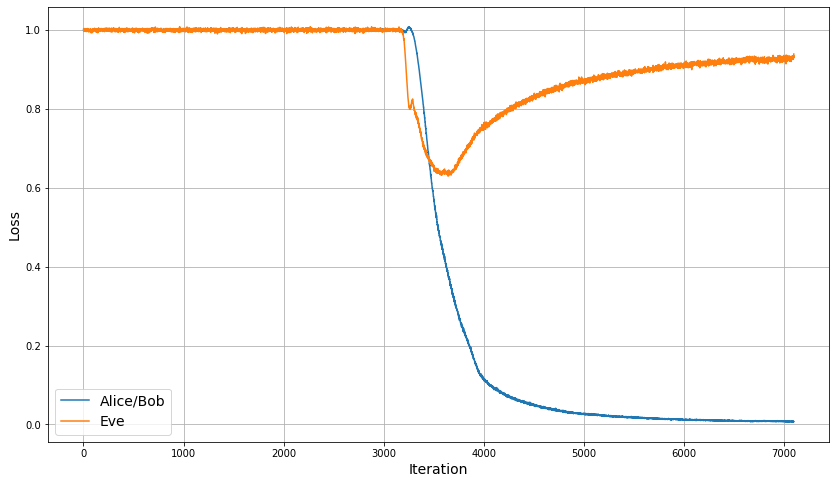

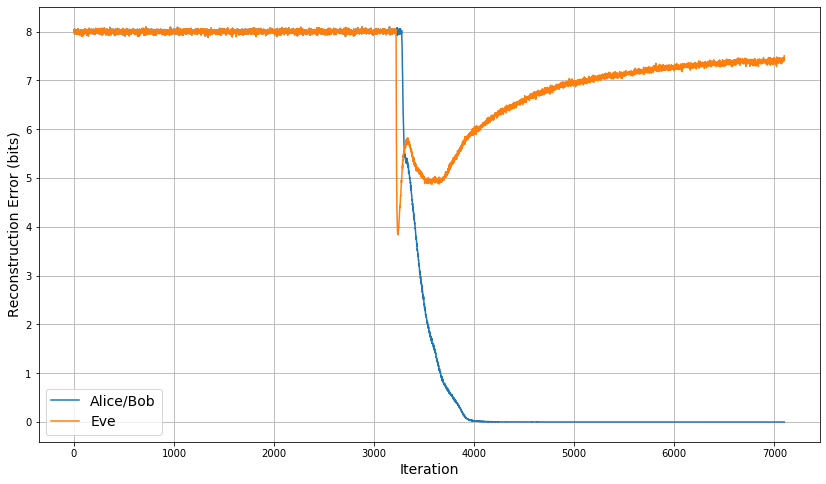

In [32]:
plot_abe_losses(ABs, Es)
plot_abe_losses(RBs, ERs, ylabel="Reconstruction Error (bits)")

In [33]:
def test_enc(A,B,E, debug=True):
    with torch.no_grad():
        P = gen_bitstring(N, batch_size=1)
        K = gen_bitstring(N, batch_size=1)
        C = A(torch.cat((P, K), dim=1))
        D = B(torch.cat((C, K), dim=1))
        F = E(C)
        if debug:
            print ("P:\n", P.cpu())
            print ("K:\n", K.cpu())
            print ("A(P,K):\n", C.cpu())
            print ("B(A(P, K), K):\n", D.cpu())
            print ("E(A(P, K)):\n", F.cpu())
        return P, K, C, D, F

In [34]:
_ = test_enc(A,B,E, debug=True)

P:
 tensor([[-1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
          1., -1.]])
K:
 tensor([[-1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
         -1., -1.]])
A(P,K):
 tensor([[-0.2108, -0.4068,  0.5591,  0.5356, -0.5933,  0.5051,  0.5608, -0.4685,
          0.5518, -0.3741,  0.7064, -0.6699,  0.5502, -0.6388,  0.5095,  0.6827]])
B(A(P, K), K):
 tensor([[-0.9982,  0.9986, -0.9991, -0.9953,  0.9994, -0.9992, -0.9993, -0.9986,
          0.9992,  0.9995, -0.9961, -0.9981, -0.9992,  0.9990,  0.9981, -0.9973]])
E(A(P, K)):
 tensor([[-0.9996, -0.9998, -0.9999,  0.9998, -0.9998, -0.9998, -0.9998,  1.0000,
          0.9999, -0.9998,  1.0000, -0.9956, -0.9999, -0.9998, -0.9998,  1.0000]])


In [35]:
def test_BE(A, B, E):
    TEST_SIZE = 10000
    B_rec = 0
    E_rec = 0
        
    for I in range(TEST_SIZE):
        P, K, C, P_b, P_e = test_enc(A,B,E, debug=False)
        B_rec += reconstruction_error(P, P_b)
        E_rec += reconstruction_error(P, P_e)
    return B_rec/TEST_SIZE, E_rec/TEST_SIZE

testB, testE = test_BE(A, B, E)
print ("B: {:.4f}".format(testB))
print ("E: {:.4f}".format(testE))


B: 0.0000
E: 7.4283


In [36]:
def train_best_eve(A, E,
                   max_iter=250000,
                   retries=5,
                   debug_print=10000):

    Best_E_Rec = float("Inf")
    Best_E_loss = float("Inf")
    Best_E = None

    for es in range(retries):
        CE = ABENet(N, has_key=False).to(DEVICE)
        CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
        CE.train()
        start_time = time.time()
        for ic in range(max_iter):
            P = gen_bitstring(N, batch_size=minibatch_size)
            K = gen_bitstring(N, batch_size=minibatch_size)
                   
            C       = A(torch.cat((P, K), dim=1))
            P_eve   = CE(C)
            CE_loss = loss_eve(P_eve, P)
            CE_optimizer.zero_grad()
            CE_loss.backward()
            CE_optimizer.step()

            if debug_print > 0 and ic % debug_print == (debug_print-1):
                elapsed_time = time.time() - start_time
                print("[{:d} - {:6d}] CE_loss: {:2.4f} Elapsed Time: {}".format(
                    es+1, ic+1, CE_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

            if CE_loss <= 0.05:
                raise RuntimeError("Optimal E found!")
                break
            
        if CE_loss.item() < Best_E_loss:
            Best_E_loss = CE_loss.item()
            Best_E = CE
            Best_E_Rec = reconstruction_error(P, P_eve)

    return Best_E, Best_E_loss, Best_E_Rec

In [38]:
Best_E, Best_E_loss, Best_E_Rec = train_best_eve(A, E, retries=1, max_iter=20000)
Best_E_loss

[1 -  10000] CE_loss: 0.8267 Elapsed Time: 00:01:39


[1 -  20000] CE_loss: 0.8188 Elapsed Time: 00:03:18


0.8187873959541321

In [39]:
# Train new A,B,E and validate them for 20 times
def validate(num_times=20, max_iter_abe=15000, retries=5, max_iter_e=15000):
    AB     = []
    AB_rec = []
    BE     = []
    BE_rec = []
    start_time = time.time()
    for n in range(num_times):
        A = ABENet(N, has_key=True).to(DEVICE)
        B = ABENet(N, has_key=True).to(DEVICE)
        E = ABENet(N, has_key=False).to(DEVICE)
        ABs, Es, RABs, REs = train_abe(A,B,E, max_iter=max_iter_abe, debug_print=5000)
        _, Best_E_loss, BRE = train_best_eve(
            A, E, retries=retries, max_iter=max_iter_e, debug_print=7500)
        AB.append(ABs[-1])
        AB_rec.append(RABs[-1])
        BE.append(Best_E_loss)
        BE_rec.append(BRE)
        elapsed_time = time.time() - start_time
        print("[N: {}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            n+1, ABs[-1], Best_E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

    return AB, BE, AB_rec, BE_rec


In [40]:
AB, BE, AB_rec, BE_rec = validate(num_times=5, retries=5, max_iter_abe=15000, max_iter_e=15000)

[  5000] AB_loss: 1.0015 E_loss: 0.9952 Elapsed Time: 00:02:52


[1 -   7500] CE_loss: 0.7583 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.7390 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.7705 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.7628 Elapsed Time: 00:02:29


[3 -   7500] CE_loss: 0.7422 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.7424 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.7452 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.7327 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.7491 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.7414 Elapsed Time: 00:02:28
[N: 1] AB_loss: 0.0069 E_loss: 0.7327 Elapsed Time: 00:17:56


[  5000] AB_loss: 0.0096 E_loss: 0.9216 Elapsed Time: 00:02:52


[1 -   7500] CE_loss: 0.8409 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8369 Elapsed Time: 00:02:29


[2 -   7500] CE_loss: 0.8428 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8426 Elapsed Time: 00:02:29


[3 -   7500] CE_loss: 0.8666 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.8595 Elapsed Time: 00:02:29


[4 -   7500] CE_loss: 0.8581 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8541 Elapsed Time: 00:02:29


[5 -   7500] CE_loss: 0.8497 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8357 Elapsed Time: 00:02:28
[N: 2] AB_loss: 0.0072 E_loss: 0.8357 Elapsed Time: 00:33:39


[  5000] AB_loss: 0.1218 E_loss: 0.7666 Elapsed Time: 00:02:52


[1 -   7500] CE_loss: 0.8450 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8368 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.8428 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8374 Elapsed Time: 00:02:28


[3 -   7500] CE_loss: 0.8262 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.8289 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.8212 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8273 Elapsed Time: 00:02:29


[5 -   7500] CE_loss: 0.8642 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8624 Elapsed Time: 00:02:28
[N: 3] AB_loss: 0.0071 E_loss: 0.8273 Elapsed Time: 00:50:51


[  5000] AB_loss: 0.9998 E_loss: 0.9954 Elapsed Time: 00:02:52


[ 10000] AB_loss: 0.0535 E_loss: 0.8882 Elapsed Time: 00:05:44


[1 -   7500] CE_loss: 0.6710 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.6559 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.6295 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.6323 Elapsed Time: 00:02:29


[3 -   7500] CE_loss: 0.6646 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.6502 Elapsed Time: 00:02:29


[4 -   7500] CE_loss: 0.6379 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.6284 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.6587 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.6476 Elapsed Time: 00:02:28
[N: 4] AB_loss: 0.0076 E_loss: 0.6284 Elapsed Time: 01:09:58


[  5000] AB_loss: 0.1490 E_loss: 0.8168 Elapsed Time: 00:02:52


[ 10000] AB_loss: 0.0365 E_loss: 0.9426 Elapsed Time: 00:05:44


[ 15000] AB_loss: 0.0329 E_loss: 0.9642 Elapsed Time: 00:08:36


[1 -   7500] CE_loss: 0.8852 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8702 Elapsed Time: 00:02:29


[2 -   7500] CE_loss: 0.8925 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8754 Elapsed Time: 00:02:28


[3 -   7500] CE_loss: 0.8716 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.8526 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.8682 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8681 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.8815 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8631 Elapsed Time: 00:02:29
[N: 5] AB_loss: 0.0329 E_loss: 0.8526 Elapsed Time: 01:31:00


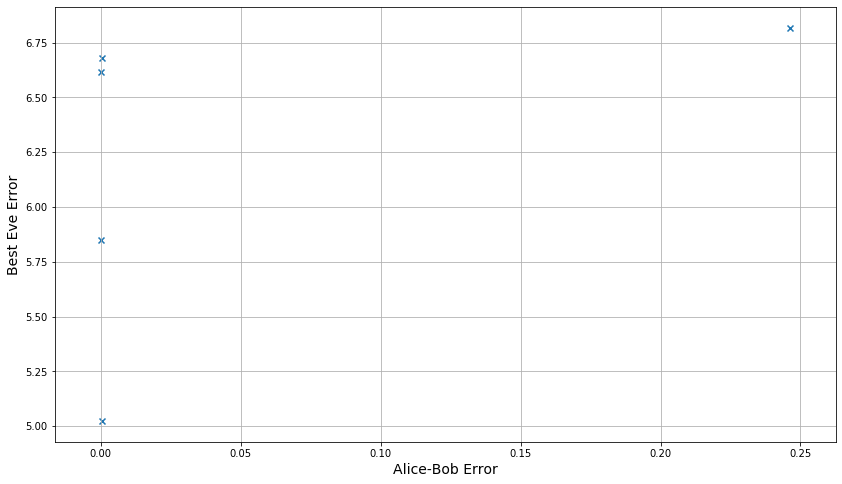

In [41]:
def plot_best_eves(AB, BE):
    plt.figure(figsize=(14,8))
    plt.scatter(AB,BE, marker='x')
    plt.xlabel("Alice-Bob Error", fontsize=14)
    plt.ylabel("Best Eve Error", fontsize=14)
    plt.grid(True, which='both')
    plt.show()

plot_best_eves(AB_rec, BE_rec)

In [ ]:
_, _, AB_rec_1, BE_rec_1 = validate(num_times=10, retries=5, max_iter_abe=15000, max_iter_e=15000)
plot_best_eves(AB_rec_1, BE_rec_1)

[  5000] AB_loss: 0.0662 E_loss: 0.8058 Elapsed Time: 00:02:52


[1 -   7500] CE_loss: 0.7719 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.7725 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.7763 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.7765 Elapsed Time: 00:02:28


[3 -   7500] CE_loss: 0.7780 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.7776 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.8100 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8063 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.7688 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.7688 Elapsed Time: 00:02:28
[N: 1] AB_loss: 0.0079 E_loss: 0.7688 Elapsed Time: 00:16:35


[  5000] AB_loss: 0.0258 E_loss: 0.8721 Elapsed Time: 00:02:52


[1 -   7500] CE_loss: 0.8493 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8261 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.8347 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8296 Elapsed Time: 00:02:29


[3 -   7500] CE_loss: 0.8305 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.8246 Elapsed Time: 00:02:29


[4 -   7500] CE_loss: 0.8619 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8560 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.8477 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8452 Elapsed Time: 00:02:28
[N: 2] AB_loss: 0.0073 E_loss: 0.8246 Elapsed Time: 00:32:57


[  5000] AB_loss: 0.9997 E_loss: 0.9968 Elapsed Time: 00:02:52


[ 10000] AB_loss: 0.0397 E_loss: 0.9284 Elapsed Time: 00:05:44


In [35]:
# Paper Loss function with - sign
A_1 = ABENet(N, has_key=True).to(DEVICE)
B_1 = ABENet(N, has_key=True).to(DEVICE)
E_1 = ABENet(N, has_key=False).to(DEVICE)

l1_norm_1 = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
#l1_norm_1 = nn.L1Loss()
loss_eve_1 = l1_norm_1
loss_bob_1 = l1_norm_1

def loss_alicebob_1(P_bob, P_eve, P):
    lb = loss_bob_1(P_bob, P)
    le = (((N/2 - loss_eve_1(P_eve, P))**2) / ((N/2)**2))
    return lb + le

ABs_1, Es_1, B_error, E_error = train_abe(A_1, B_1, E_1,
                        max_iter=15000, loss_eve=loss_eve_1, loss_alicebob=loss_alicebob_1)

[  1000] AB_loss: 5.8366 E_loss: 3.1866 Elapsed Time: 00:00:34


[  2000] AB_loss: 1.2835 E_loss: 2.1125 Elapsed Time: 00:01:08


[  3000] AB_loss: 0.9337 E_loss: 3.4949 Elapsed Time: 00:01:42


[  4000] AB_loss: 0.5681 E_loss: 6.8130 Elapsed Time: 00:02:17


[  5000] AB_loss: 0.4940 E_loss: 7.8134 Elapsed Time: 00:02:51


[  6000] AB_loss: 0.5150 E_loss: 7.8248 Elapsed Time: 00:03:26


[  7000] AB_loss: 0.5092 E_loss: 7.9607 Elapsed Time: 00:04:00


[  8000] AB_loss: 0.5271 E_loss: 7.9084 Elapsed Time: 00:04:34


[  9000] AB_loss: 0.5023 E_loss: 7.9208 Elapsed Time: 00:05:09


[ 10000] AB_loss: 0.5269 E_loss: 8.2017 Elapsed Time: 00:05:43


[ 11000] AB_loss: 0.5171 E_loss: 7.9851 Elapsed Time: 00:06:17


[ 12000] AB_loss: 0.5093 E_loss: 8.0584 Elapsed Time: 00:06:52


[ 13000] AB_loss: 0.5024 E_loss: 8.0073 Elapsed Time: 00:07:26


[ 14000] AB_loss: 0.5115 E_loss: 7.9435 Elapsed Time: 00:08:00


[ 15000] AB_loss: 0.4982 E_loss: 7.9031 Elapsed Time: 00:08:35


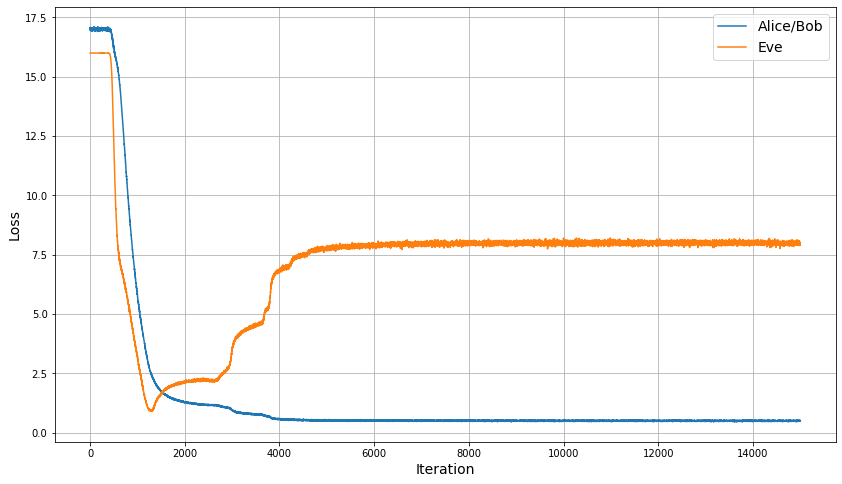

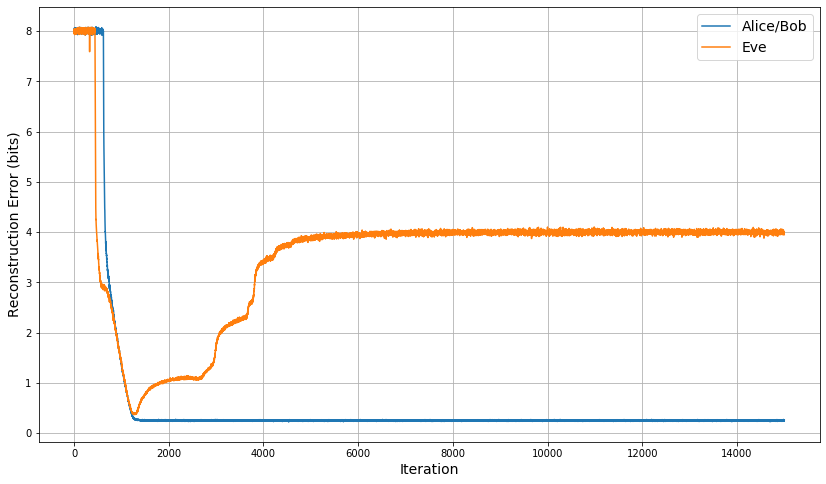

In [38]:
plot_abe_losses(ABs_1, Es_1)
plot_abe_losses(B_error, E_error, ylabel="Reconstruction Error (bits)")

[  1000] AB_loss: 5.7186 E_loss: 4.0736 Elapsed Time: 00:00:34


[  2000] AB_loss: 2.2708 E_loss: 4.5260 Elapsed Time: 00:01:09


[  3000] AB_loss: 1.8891 E_loss: 6.6428 Elapsed Time: 00:01:43


[  4000] AB_loss: 1.8267 E_loss: 7.4230 Elapsed Time: 00:02:18


[  5000] AB_loss: 1.5280 E_loss: 7.8007 Elapsed Time: 00:02:52


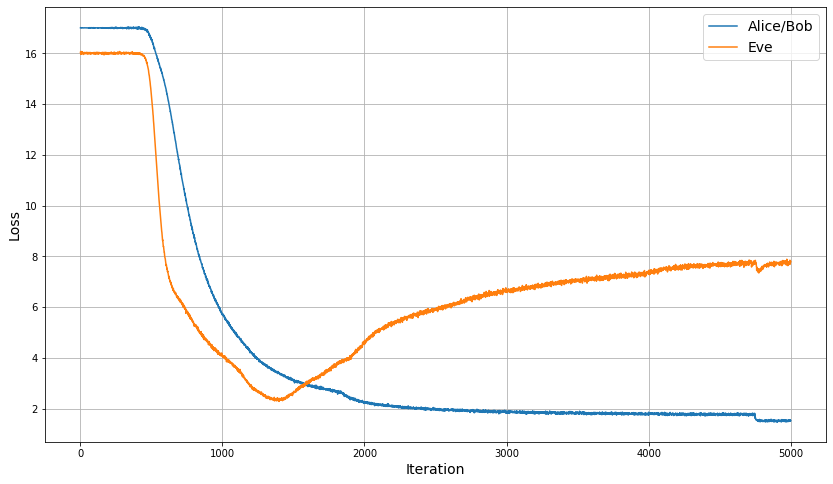

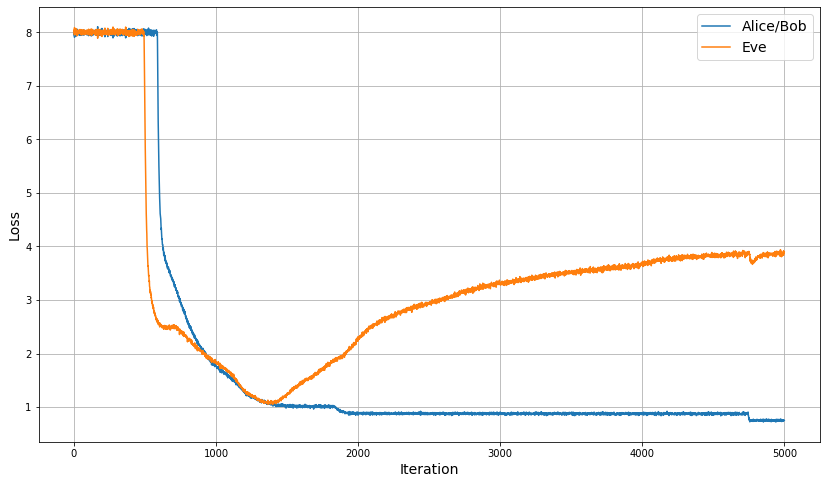

In [56]:
# Paper Loss function with + sign
A_2 = ABENet(N, has_key=True).to(DEVICE)
B_2 = ABENet(N, has_key=True).to(DEVICE)
E_2 = ABENet(N, has_key=False).to(DEVICE)

loss_alicebob_2 = lambda P_bob, P_eve, P: loss_bob_1(P_bob, P) + (((N/2 - loss_eve_1(P_eve, P))**2) / ((N/2)**2))

ABs_2, Es_2, B_error_2, E_error_2 = train_abe(A_2, B_2, E_2,
                        max_iter=5000, loss_eve=loss_eve_1, loss_alicebob=loss_alicebob_2)
plot_abe_losses(ABs_2, Es_2)
plot_abe_losses(B_error_2, E_error_2)